In [21]:
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [22]:
import numpy as np

from scipy.stats import norm

import pandas as pd

from matplotlib import pyplot as plt

from utils import configs, fitting

import importlib
importlib.reload(configs)
importlib.reload(fitting)

configs.set_plot_configs()

In [23]:
def is_float_convertible(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

vec_check = np.vectorize(is_float_convertible)

In [24]:
class GaussianFitter(fitting.BaseFitter):
    def __init__(self, 
                 g_bin_centers, g_hist, g_hist_err,
                 g_median, g_mad):
        mask = g_hist > 0

        super().__init__(x=g_bin_centers[mask],
                         y=g_hist[mask],
                         yerr=g_hist_err[mask])

        self.g_median = g_median
        self.g_mad = g_mad
        
    def _get_initial_guess(self):
        return [self.g_median, self.g_mad]
    
    def _get_model(self,x,params):
        return norm.pdf(x, loc=params[0], scale=params[1])

In [25]:
class gMeasurement:
    def __init__(self,data_file='pendulumData.csv'):
        self._read_data(data_file)

        self._get_stats()
        self._estimate_distribution_mean()

        self._bin_data()

    def _read_data(self,data_file):
        df = pd.read_csv(data_file)

        self.g = df['g (m/s2)']
        self.e_g_stat = df['stat uncert']
        self.e_g_sys = df['sys uncert']

        mask = np.logical_and(vec_check(self.g), vec_check(self.e_g_stat), vec_check(self.e_g_sys))
        self.g = np.array(self.g)[mask].astype(float)
        self.e_g_stat = np.array(self.e_g_stat)[mask].astype(float)
        #self.e_g_sys = np.array(self.e_g_sys)[mask].astype(float)

        mask = self.e_g_stat > 0
        self.g = self.g[mask]
        self.e_g_stat = self.e_g_stat[mask]

    def _get_stats(self):
        self.g_mean = np.average(self.g, weights=1/(self.e_g_stat**2))
        self.g_std = np.average((self.g - self.g_mean)**2, weights=1/(self.e_g_stat**2))**0.5

        self.g_median = np.median(self.g)
        self.g_mad = np.median(np.abs(self.g - self.g_median))

    def _estimate_distribution_mean(self):
        self.g_dist_mean = np.average(self.g, weights=1/(self.e_g_stat**2))
        self.g_dist_mean_err = self.g_dist_mean / np.sqrt(len(self.g))

    def _clip_data(self):
        mask = np.logical_and(
            self.g > self.g_median - 5*self.g_mad,
            self.g < self.g_median + 5*self.g_mad
        )

        self.g = self.g[mask]
        self.e_g_stat = self.e_g_stat[mask]
        self.e_g_sys = self.e_g_sys[mask]

    def _bin_data(self,bins=None):
        bins = np.linspace(self.g_median - 5*self.g_mad, self.g_median + 5*self.g_mad, 51)
        self.g_hist, self.g_bins = np.histogram(self.g, bins=bins)
        self.g_bin_centers = (self.g_bins[1:] + self.g_bins[:-1]) / 2
        self.g_hist_err = np.sqrt(self.g_hist)

        self.norm_factor = 1 / np.sum(self.g_hist) / (self.g_bins[1] - self.g_bins[0])
        self.g_hist = self.g_hist * self.norm_factor
        self.g_hist_err = self.g_hist_err * self.norm_factor

    def show_data(self,fitter=None):
        fig, ax = plt.subplots(figsize=(9,7))

        ax.errorbar(
            self.g_bin_centers, self.g_hist, yerr=self.g_hist_err,
            fmt=' s', markersize=7.5,elinewidth=3,capsize=7.5,alpha=0.75,
            color='maroon',label='Data'
        )

        ax.bar(self.g_bin_centers, self.g_hist, width=self.g_bins[1]-self.g_bins[0],
               color='maroon', edgecolor='none', alpha=0.3, align='center')

        ax_extra = ax.twinx()
        ax_extra.axvline(self.g_mean, color='maroon', linestyle='--', alpha=0.8)
        ax_extra.axvline(self.g_mean - self.g_std, color='maroon', linestyle='--', dashes=(1.5,2), alpha=0.8)
        ax_extra.axvline(self.g_mean + self.g_std, color='maroon', linestyle='--', dashes=(1.5,2),  alpha=0.8)

        ax_extra.axvline([100], color='black', ls='--', label='Mean')
        ax_extra.axvline([100], color='black', ls='--', dashes=(1.5,2), label='Std.')

        if fitter:
            fitting_results = fitter.fit()
            print(fitting_results)
            dense_g = np.linspace(self.g_bin_centers[0], self.g_bin_centers[-1], 1001)
            ax.plot(dense_g, fitter._get_model(dense_g,fitting_results['params']), 
                    color='darkcyan',label='Fit')
            
            ax_extra.axvline(fitting_results['params'][0], color='darkcyan', linestyle='--', alpha=0.8)
            ax_extra.axvline(fitting_results['params'][0] - fitting_results['params'][1], color='darkcyan', linestyle='--', dashes=(1.5,2), alpha=0.8)
            ax_extra.axvline(fitting_results['params'][0] + fitting_results['params'][1], color='darkcyan', linestyle='--', dashes=(1.5,2), alpha=0.8)
            
        ax.text(0.035, 0.625, r' $\,\bar{g} = $' + f'{self.g_mean:.02f}' + r'$\, [$m$\,$s$^{-2}]$',transform=ax.transAxes, fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center')
        ax.text(0.035, 0.525, r'$\sigma_{g} = $' + f'{self.g_std:.02f}' + r'$\, [$m$\,$s$^{-2}]$',transform=ax.transAxes, fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center')
        ax.text(0.035, 0.425, r' $N = $' + f'{len(self.g)}',transform=ax.transAxes, fontsize=24, rotation=0, horizontalalignment='left', verticalalignment='center')

        ax.set_xlabel(r'$g \, [$m$\,$s$^{-2}]$')
        ax.set_ylabel(r'$p (g) \, [$m$^{-1} \, $s$^{2}]$')

        ax.text

        ax.legend(loc='upper left', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)
        ax_extra.legend(loc='upper right', ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5, fontsize=24)
        ax_extra.set_yticks([])
        ax.tick_params(axis='both', which='both',direction='in',right=True)

        ax.set_xlim([self.g_bin_centers[0], self.g_bin_centers[-1]])

        plt.tight_layout()
        plt.savefig('g_measurements.png')

        plt.show()

{'params': array([9.80715177, 0.04329101]), 'e_params': array([0.00049746, 0.00051787]), 'chisqr': 127.1401064043044, 'alpha': 5.2347237655681056e-11, 'cov': array([[ 2.47470925e-07, -7.25084068e-08],
       [-7.25084068e-08,  2.68192703e-07]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


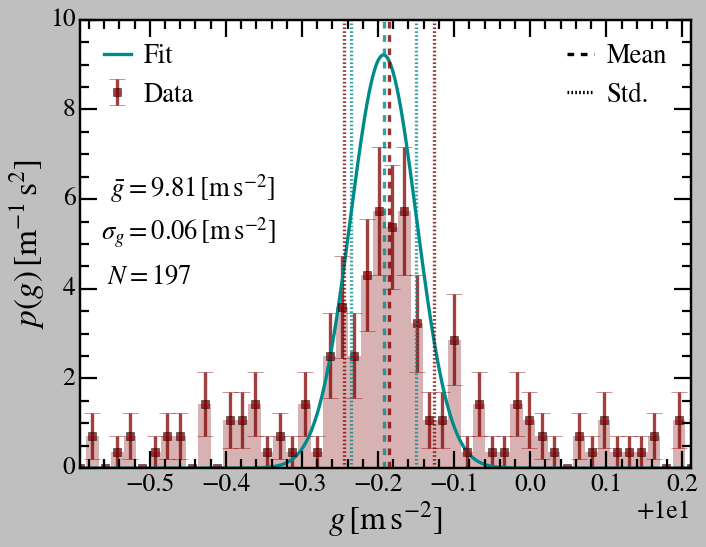

In [26]:
measurement = gMeasurement()
fitter = GaussianFitter(measurement.g_bin_centers, measurement.g_hist, measurement.g_hist_err, 
                        measurement.g_median, measurement.g_mad)
measurement.show_data(fitter)

In [30]:
from scipy.stats import poisson

1 - poisson.pmf(0, 2*11/12) * poisson.pmf(2, 2*1/12)

0.9981203432883804